# House Prices Prediction

Predict sales prices and practice feature engineering, RFs, and gradient boosting

First step is to load the dataset, indentify the target (dependant) variable (SalePrice), and take a look at the different variables and its datatypes.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew

# import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
#jupyter nbconvert src/startups_study.ipynb --no-input --to html

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)

In [3]:
pd.read_csv('data/train.csv').head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


Convert the default datatype (object) to more appropiate datatypes like category and datetime.

In [2]:
target_variable = 'SalePrice'

cat_columns = [
    'MSSubClass', 'category', 'Street', 'Alley', 'LotShape',
    'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
    'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
    'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional',
    'FireplaceQu', 'GarageType', 'GarageQual', 'GarageFinish', 'PavedDrive', 'MiscFeature',
    'SaleType', 'SaleCondition',
    'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', # <- ordered categories 
    # 'Utilities', 

]
date_columns = [
    'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 
]
bool_columns = [
    'CentralAir', 
]

cat_dict = {
    c: 'category' for c in cat_columns
}
bool_dict = {
    b: 'bool' for b in bool_columns
}
columns_types = cat_dict.update(bool_dict)
# columns_types = cat_dict | bool_dict


In [5]:
train = pd.read_csv(
    'data/train.csv',
    true_values = ['Y'],
    false_values = ['N'],
    dtype=columns_types,
    # parse_dates=date_columns,
)

test = pd.read_csv(
    'data/test.csv',
    true_values = ['Y'],
    false_values = ['N'],
    dtype=columns_types,
    # parse_dates=date_columns,
)

print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

ntrain = train.shape[0]
ntest = test.shape[0]
Y_train = train['SalePrice'].values

all_df = pd.concat((train, test)).reset_index(drop=True)
all_df.drop(['SalePrice'], axis=1, inplace=True)

print(f'all_df shape: {all_df.shape}')

train shape: (1460, 81)
test shape: (1459, 80)
all_df shape: (2919, 79)


## Handle missing values

Before doing any analysis, lets try to figure it out how to handle missing values (NaN).  
First, lets take a look at the missing values in each column in a graphical way:

<AxesSubplot:>

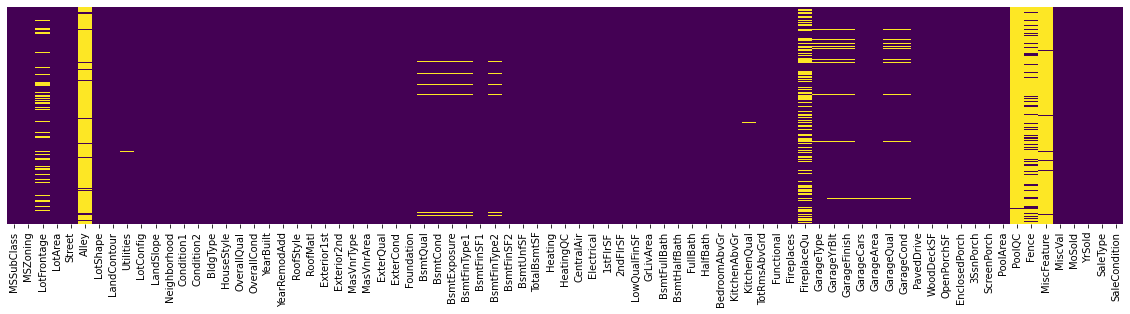

In [6]:
plt.figure(figsize=(20,4))
sns.heatmap(
    all_df.isnull(), 
    yticklabels=False, 
    cbar=False, 
    cmap='viridis',
)

Some columns like *Alley* and *PoolQC* look like have almost all values missing.  
However, if you take a look at the data_description.txt file you'll see those values are not missing but just means this houses have no pool (for example).  
So in this case I opted for adding a new category (to those columns where NaN does not mean missing value) for these cases.  


In [7]:
for cat in all_df.columns[all_df.isnull().any()]:
    if cat in all_df.select_dtypes(include=['category']).columns:
        if 'None' not in all_df[cat].cat.categories:
            all_df[cat] = all_df[cat].cat.add_categories('None')
        all_df[cat] = all_df[cat].fillna('None')
all_df['PoolQC'] = all_df['PoolQC'].fillna('None')
all_df['MiscFeature'] = all_df['MiscFeature'].fillna('None')
all_df['GarageQual'] = all_df['GarageQual'].fillna('None')
all_df["MasVnrArea"] = all_df["MasVnrArea"].fillna(0)

LotFrontage is most likely similar for all houses in the same neightbourhood so we can fill NaNs with the neighbourhood median.

In [8]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_df['LotFrontage'] = all_df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

Almost all rows have the same utilities value so it doesn't provide much information, we can drop this column

In [9]:
all_df = all_df.drop(['Utilities'], axis=1)

Fill Garage Information with 0 for houses without a garage.

In [10]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_df[col] = all_df[col].fillna(0)

<AxesSubplot:>

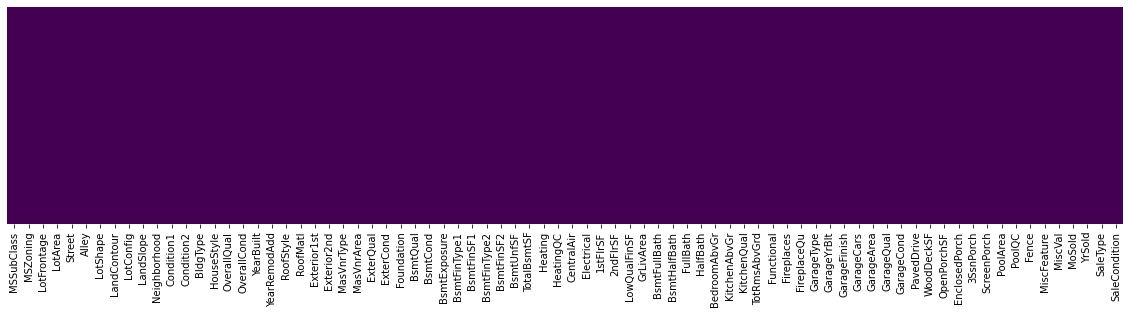

In [11]:
plt.figure(figsize=(20,4))
sns.heatmap(
    all_df.isnull(), 
    yticklabels=False, 
    cbar=False, 
    cmap='viridis',
)

Now that we don´t have any missing values, let's start the data exploration.

## Data exploration
First, let's start by taking a look at the target variable SalePrice:

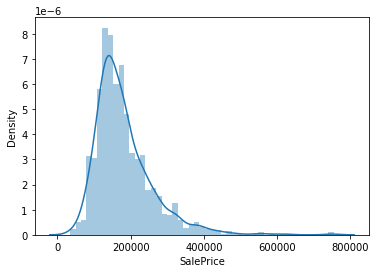

In [12]:
sns.distplot(train['SalePrice']);

We can see that SalePrice deviates from the normal dsitribution and have a high positive skewness

In [13]:
#skewness and kurtosis
print(f'Skewness: {train["SalePrice"].skew()}')
print(f'Kurtosis: {train["SalePrice"].kurt()}')

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


Now lets create a correlation matrix to get the variables that have a higher impact in the variation of the SalePrice:

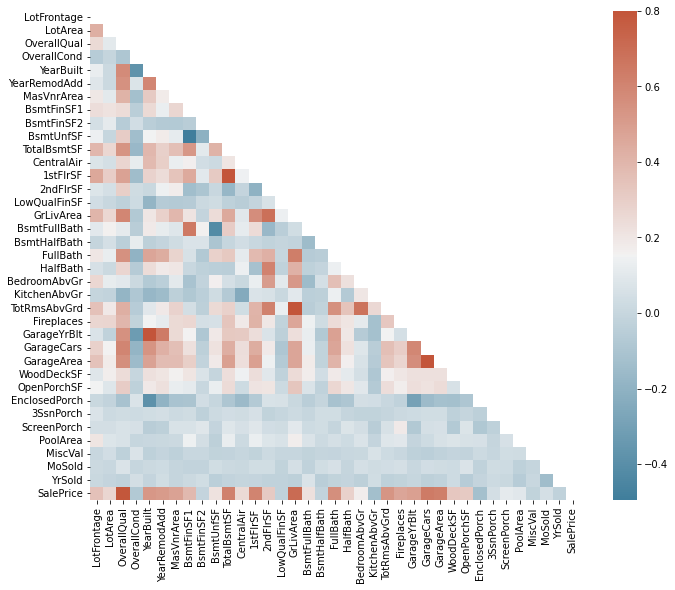

In [14]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    corr,
    cmap=cmap,
    vmax=.8,
    square=True,
    mask=mask
);

Now lets take a closer look to the most correlated variables to SalePrice

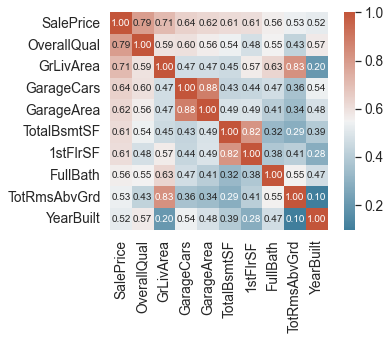

In [15]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(
    cm,
    cbar=True,
    annot=True,
    square=True,
    cmap=cmap,
    fmt='.2f',
    annot_kws={'size': 10},
    yticklabels=cols.values,
    xticklabels=cols.values
)
plt.show()

Quick look to the scatter plots of the relationship of the most correlated variables with SalePrice 

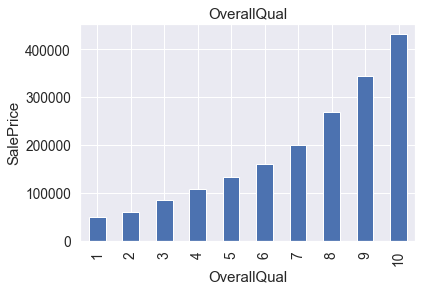

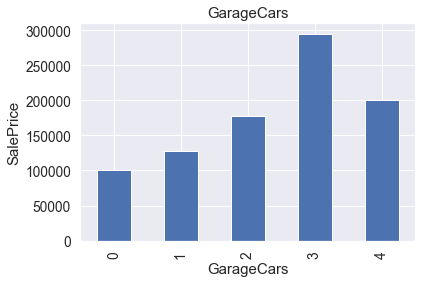

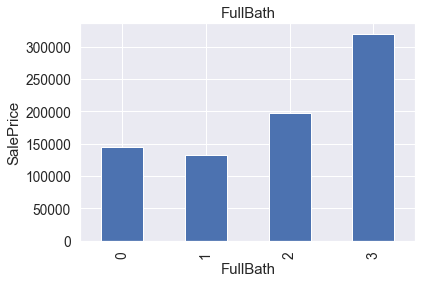

In [18]:
cols = ['OverallQual', 'GarageCars', 'FullBath']
for feature in cols:
    train.groupby(feature)['SalePrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.show()

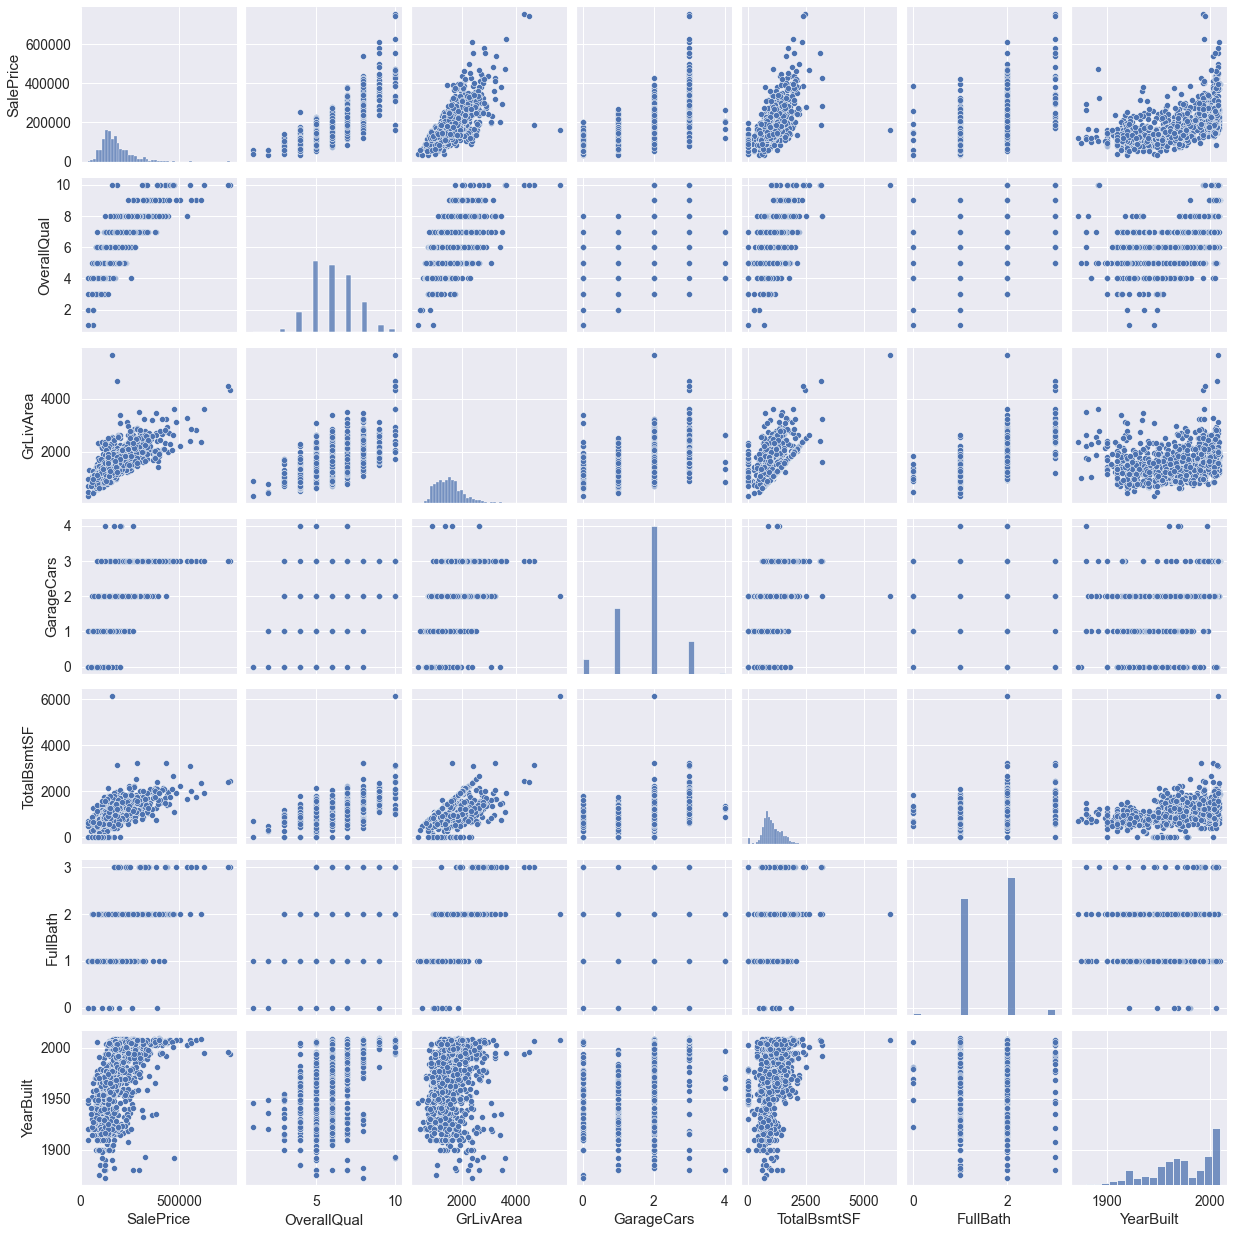

In [19]:
#scatterplot
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(
    train[cols],
    size = 2.5
)
plt.show();

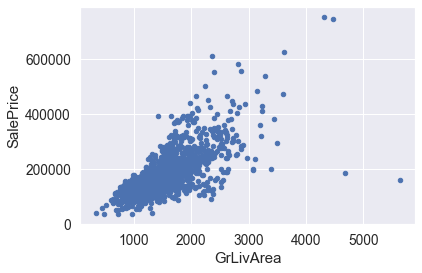

In [20]:
train.plot.scatter(
    x='GrLivArea',
    y='SalePrice',
    color='b',
);

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

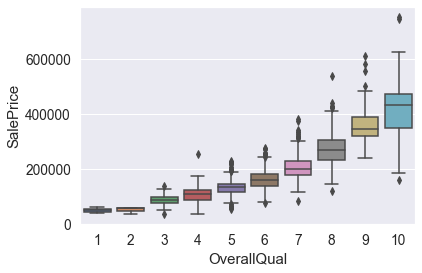

In [21]:
# boxplots are better than scatterplots for categorical values
sns.boxplot(
    data=train,
    x='OverallQual',
    y='SalePrice',
)

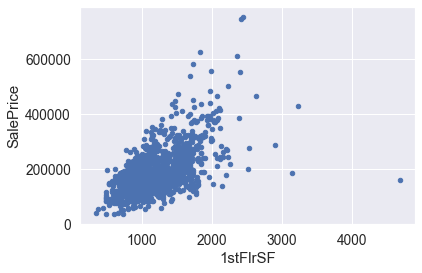

In [22]:
train.plot.scatter(
    # train,
    x='1stFlrSF',
    y='SalePrice',
    color='b',
);

## Handling Outliers
First, standarize the data to have 0 mean and 1 stdv,
then take a look at the higher and lower ranges of values.

In [23]:
#standardizing data
saleprice_scaled = ((Y_train-Y_train.mean())/Y_train.std())
saleprice_scaled.sort()
low_range = saleprice_scaled[:10]
high_range = saleprice_scaled[-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[-1.83870376 -1.83352844 -1.80092766 -1.78329881 -1.77448439 -1.62337999
 -1.61708398 -1.58560389 -1.58560389 -1.5731    ]

outer range (high) of the distribution:
[3.82897043 4.04098249 4.49634819 4.71041276 4.73032076 5.06214602
 5.42383959 5.59185509 7.10289909 7.22881942]


In [24]:
#deleting points
train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,True,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,True,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [25]:

train = train.drop(train[train_ID == 1299].index)
train = train.drop(train[train_ID == 524].index)

## Modelling the data

> Data with a normal distribution works better in ML models.

- Histogram -> Kurtosis and skewness.
- Normal probability plot -> Data distribution should closely follow the diagonal that represents the normal distribution.

In [26]:
numeric_feats = all_df.dtypes[all_df.dtypes == 'int64'].index

# Check the skew of all numerical features
skewed_feats = all_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print('Skew in numerical features:')
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

Skew in numerical features:


,Skew
MiscVal,21.947
PoolArea,16.898
LotArea,12.822
LowQualFinSF,12.089
3SsnPorch,11.376
KitchenAbvGr,4.302
EnclosedPorch,4.004
ScreenPorch,3.947
OpenPorchSF,2.535
WoodDeckSF,1.842


In [27]:
def plot_dist(data) -> None:
    fig = plt.figure()
    sns.distplot(data, fit=norm);
    fig = plt.figure()
    res = stats.probplot(data, plot=plt)

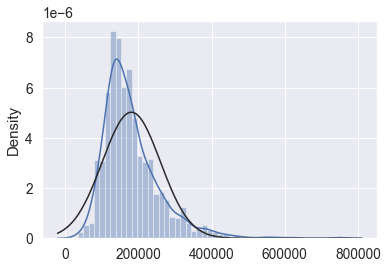

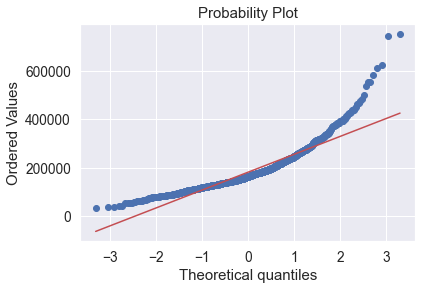

In [28]:
plot_dist(Y_train)

The SalePrice distribution doesn't have a normal distribution, but we know that positive skewed dsitributions often can be corrected with a logaritmic transformation

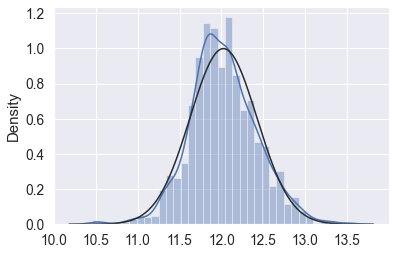

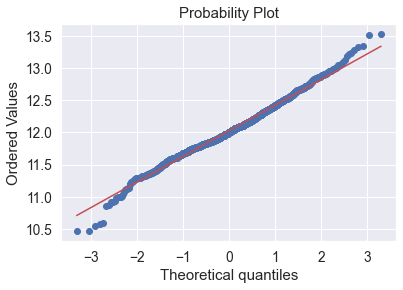

In [29]:
# first lets see if works
plot_dist(np.log1p(Y_train))

Let's try other common transformations:  
- Reciprocal Transformation
- Square Root Transformation
- Exponential Transformation
- Box-Cox Transformation
    

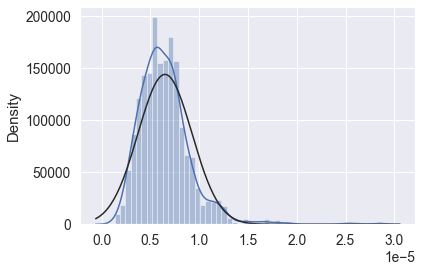

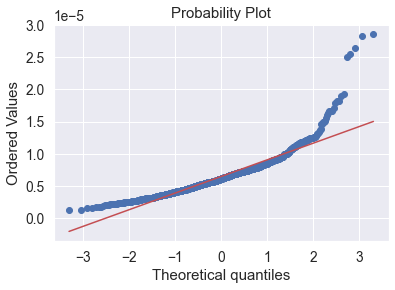

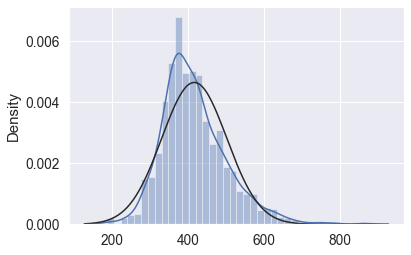

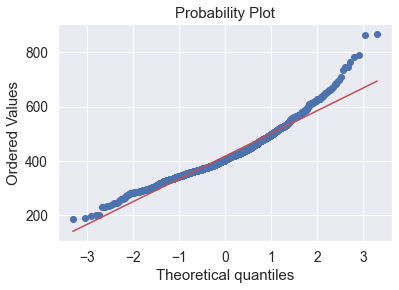

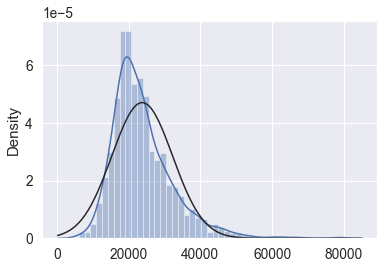

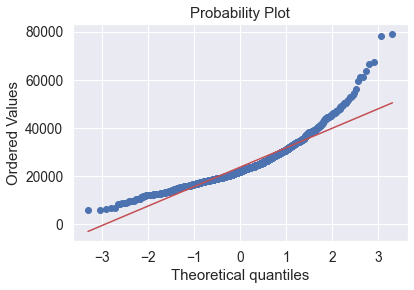

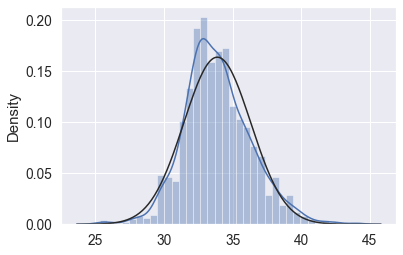

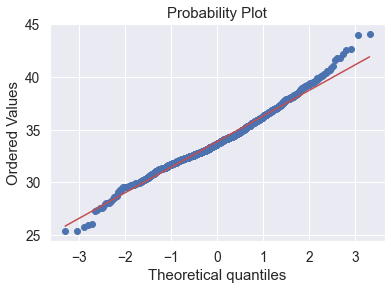

In [30]:
from scipy.special import boxcox1p
plot_dist(1/Y_train)
plot_dist(np.sqrt(Y_train))
plot_dist(Y_train**(1/1.2))
plot_dist(boxcox1p(Y_train, 0.15))

It worked, so let's apply the transformation

In [31]:
Y_train = np.log1p(Y_train)

Let's continue with other variables distribution

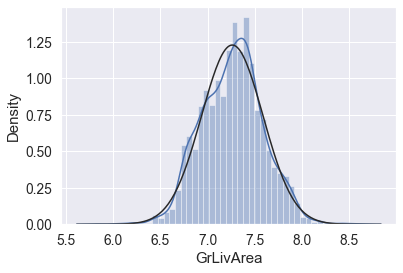

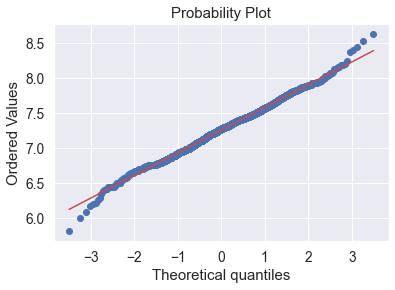

In [32]:
#histogram and normal probability plot
plot_dist(np.log(all_df['GrLivArea']))

In [33]:
all_df['GrLivArea'] = np.log(all_df['GrLivArea'])

In [34]:
skewness = skewness[abs(skewness) > 0.75]
skewed_features = skewness.index
for feat in skewed_features:
    if feat is 'GrLivArea': continue
    all_df[feat] = boxcox1p(all_df[feat], 0.15)

In [35]:
all_df_dummies = pd.get_dummies(all_df)
all_df_dummies.sample(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_None,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_None,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_None,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_None,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_None,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,KitchenQual_None,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Functi

In [36]:
train_dummies = all_df_dummies[:ntrain]
test_dummies = all_df_dummies[ntrain:]

print(f'train shape: {train_dummies.shape}')
print(f'test shape: {test_dummies.shape}')
print(f'Y_train shape: {Y_train.shape}')

train shape: (1460, 318)
test shape: (1459, 318)
Y_train shape: (1460,)


In [37]:
# label-encode features?
# scikit pipelines?

## Modelling


In [38]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


In [42]:
# split the train set in train/test so we can test the models with new rows
X_train, X_test, y_train, y_test = train_test_split(
    train_dummies, Y_train, test_size=0.10, random_state=42
)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (1314, 318)
X_test: (146, 318)
y_train: (1314,)
y_test: (146,)


In [43]:
# The error metric: RMSE on the log of the sale prices.
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [44]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
steps = 20  # The number of training iterations
param = {
    'colsample_bytree': 0.2, 
    'max_depth': 4,  
    # 'objective': 'multi:softprob',  
    'gamma': 0.0,
    'learning_rate': 0.01,
    'min_child_weight': 1.5,
    'n_estimators': 7200,
    'reg_alpha': 0.9,
    'reg_lambda': 0.6,
    'subsample': 0.2,
    'seed': 42,
    # 'silent': 1,
} 


In [45]:
regr = xgb.XGBRegressor(
    **param
)

regr.fit(X_train, y_train)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(X_test)
print(f'XGBoost score on training set: {rmse(y_test, y_pred)}')

XGBoost score on training set: 0.11909893337238098


In [169]:
# from sklearn.model_selection import GridSearchCV

# clf = xgb.XGBClassifier()

# parameters = {
#      'eta'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#      'max_depth'        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#      'min_child_weight' : [ 1, 1.5, 2, 2.5, 3, 5, 7 ],
#      'gamma'            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
#      'colsample_bytree' : [ 0.1, 0.2, 0.3, 0.4, 0.5 , 0.7 ],
#      'learning_rate'    : [ 0.01, 0.015, 0.02, 0.025],
#      'min_child_weight' : [ 1.0, 1.5, 2 ],
#      'n_estimators'     : [ 7200 ],
#      'reg_alpha'        : [ 0.8, 0.9 ],
#      'reg_lambda'       : [ 0.5, 0.6 ],
#      'subsample'        : [ 0.1, 0.2, 0.3 ],
#      'seed'             : [42],
#      'silent'           : [1],
# }

# grid = GridSearchCV(
#      clf,
#      parameters, n_jobs=4,
#      scoring="neg_log_loss",
#      cv=3,
# )

# grid.fit(X_train, y_train)

# y_pred = regr.predict(X_test)
# print(f'xgboost score on training set: {rmse(y_test, y_pred)}')
# regr.dump_model('dump.raw.txt')

In [46]:
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train_dummies.values, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [53]:
model_xgb = xgb.XGBRegressor(
    **param, # 0.1223
    # colsample_bytree=0.4603,
    # gamma=0.0468, 
    # learning_rate=0.05,
    # max_depth=3, 
    # min_child_weight=1.7817,
    # n_estimators=2200,
    # reg_alpha=0.4640,
    # reg_lambda=0.8571,
    # subsample=0.5213,
    # random_state=7,
    # nthread=-1,
)

In [54]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1223 (0.0094)



In [55]:
model_xgb.fit(train_dummies.values, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, missing=nan,
             monotone_constraints='()', n_estimators=7200, n_jobs=1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1, seed=42,
             subsample=0.2, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [56]:
y_pred = model_xgb.predict(X_test)
print(f'XGBoost score on training set: {rmse(y_test, y_pred)}')

XGBoost score on training set: 0.0724368657249345


In [57]:
# Run prediction on the Kaggle test set.
y_pred_xgb = model_xgb.predict(test_dummies)
xgb_pred = np.expm1(y_pred_xgb)

In [58]:
print(y_pred_xgb[:5])
print(xgb_pred[:5])

[11.754795 12.022658 12.113828 12.20041  12.117976]
[127361.81 166483.64 182375.36 198869.66 183133.52]


In [59]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv',index=False)